In [ ]:
!pip install torch torchvision tqdm

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  device = 'cuda:0'
else: device = 'cpu'
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

MPS not available because the current PyTorch install was not built with MPS enabled.


In [4]:
import torch.optim as optim

def train(model, trainloader, num_epochs):
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          # print(model.device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0
  print('Finished Training')

def run_trial(model, testloader, num_trials = 1):
  model.to(device)
  accuracy = []
  times = []
  for _ in range(num_trials):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    total_time = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            outputs = model(images)
            end.record()
            torch.cuda.synchronize()
            total_time += start.elapsed_time(end)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            # print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy.append(correct / total)
    times.append(total_time)
  accuracy = np.array(accuracy)
  times = np.array(times)
  avg_accuracy = np.mean(accuracy)
  std_accuracy = np.std(accuracy)
  avg_runtime = np.mean(times)
  std_runtime = np.std(times)
  print(f'Accuracy (Mean, StD) on the 10000 test images: {100 * avg_accuracy}, {100 * std_accuracy} %')
  print(f'Time (Mean, StD) taken: {avg_runtime}, {std_runtime} %')
  return avg_accuracy, std_accuracy, avg_runtime, std_runtime

def run_experiment(regular_net, testloader):
  acc_mean_control, acc_std_control, time_mean_control, time_std_control = run_trial(regular_net, testloader, 5)
  acc_mean, acc_std, time_mean, time_std = [], [], [], []
  trials = np.linspace(5, 100, 10)
  for t in trials:
      new_net = transform_model(regular_net, int(t))
      result = run_trial(new_net, testloader, 20)
      acc_mean.append(result[0])
      acc_std.append(result[1])
      time_mean.append(result[2])
      time_std.append(result[3])

  acc_mean = np.array(acc_mean)
  acc_std = np.array(acc_std)
  time_mean = np.array(time_mean)
  time_std = np.array(time_std)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(trials, acc_mean, color='red', label='Pruned Network')
  ax1.plot(trials, [acc_mean_control] * len(trials), color='blue', label='Regular Network ')
  ax1.fill_between(trials, acc_mean-acc_std, acc_mean+acc_std,
      alpha=0.1, color='red')

  ax1.set_title('MNIST Accuracy vs. Rank')
  ax1.set_ylabel('Accuracy (%)')

  ax1.legend(loc="lower right")


  ax2.plot(trials, time_mean, color='red', label='Pruned Network')
  ax2.plot(trials, [time_mean_control] * len(trials), color='blue', label='Regular Network')
  ax2.fill_between(trials, time_mean-time_std, time_mean+time_std,
      alpha=0.1, color='red')
  ax2.fill_between(trials, [time_mean_control - time_std_control] * len(trials), [time_mean_control + time_std_control] * len(trials),
      alpha=0.1, color='blue')

  ax2.set_title('Inference Time vs. Rank')
  ax2.set_xlabel('Rank (%)')
  ax2.set_ylabel('Time (s)')

  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)



  plt.show()

In [5]:
import pandas as pd
import numpy as np

def low_rank_approx(x, k):
  U, S, VT = np.linalg.svd(x, full_matrices=False)

  if k > min(x.shape[0], x.shape[1]):
      return torch.from_numpy(x.T).to(device), torch.from_numpy(np.eye(x.shape[0], dtype=x.dtype)).to(device)

  # total_variance = np.sum(S**2)
  # variance_99 = 0.99 * total_variance
  # sum_variance = 0
  # k = 0
  # for i in range(len(S)):
  #     sum_variance += S[i]**2
  #     k += 1
  #     if sum_variance >= variance_99:
  #         break

  S_k = np.diag(S[:k])
  U_k = U[:, :k]
  VT_k = VT[:k, :]
  A_k = np.dot(U_k, np.dot(S_k, VT_k))
  # print(U_k.T.shape, VT_k.T.shape, x.shape)
  # print(np.dot(VT_k.T, np.dot(U_k, x)))
  print(torch.from_numpy(VT_k.T).shape, torch.from_numpy(U_k.T).shape)
  return torch.from_numpy(VT_k.T).to(device), torch.from_numpy(U_k.T).to(device)


def low_rank_approx_cnn(x, k):
  U, S, VT = np.linalg.svd(x, full_matrices=False)

  if k > min(x.shape[0], x.shape[1]):
      return torch.from_numpy(x.T).to(device), torch.from_numpy(np.eye(x.shape[0], dtype=x.dtype)).to(device)

  # total_variance = np.sum(S**2)
  # variance_99 = 0.99 * total_variance
  # sum_variance = 0
  # k = 0
  # for i in range(len(S)):
  #     sum_variance += S[i]**2
  #     k += 1
  #     if sum_variance >= variance_99:
  #         break

  # S_k = np.diag(S[:k])
  U_k = U[:, :, :, :k]
  VT_k = VT[:, :, :k, :]
  # A_k = np.dot(U_k, np.dot(S_k, VT_k))
  # print(U_k.T.shape, VT_k.T.shape, x.shape)
  # print(np.dot(VT_k.T, np.dot(U_k, x)))
  print(torch.from_numpy(VT_k.transpose(0,1,3,2)).shape, torch.from_numpy(U_k.transpose(0,1,3,2)).shape)
  return torch.from_numpy(VT_k.transpose(0,1,3,2)).to(device), torch.from_numpy(U_k.transpose(0,1,3,2)).to(device)

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5), (0.5))])

batch_size = 512

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 899028.85it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133652.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1277489.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10818017.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
import torchvision.models as models
def replace_layers(net, layer_type, randomized=False):

    for name, module in net.named_children():
        if isinstance(module, layer_type):
            # print(type(module))
            layer = module
            if layer_type == nn.Conv2d:
                weight_matrix = layer.weight.data
                if layer.bias is not None:
                    bias_matrix = layer.bias.data
                new = RegularCNNLayer(in_channels=layer.in_channels,
                                      out_channels=layer.out_channels,
                                      kernel_size=layer.kernel_size,
                                      padding=layer.padding,
                                      stride=layer.stride,
                                      bias = True if layer.bias is not None else False)
                new.weight = weight_matrix
                if layer.bias is not None:
                    new.bias = bias_matrix
            setattr(net, name, new)
        elif len(list(module.children())) > 0:
            replace_layers(module, layer_type, randomized)


In [7]:
class LowRankLayer(nn.Module):
    def __init__(self, weight1, weight2, bias):
        super().__init__()
        self.weight1 = weight1
        self.weight2 = weight2
        self.bias = bias

    def forward(self, x):
        return (x @ self.weight1.T) @ self.weight2.T + self.bias

class RegularCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, padding=0, bias=True):

        super().__init__()
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        self.weight = None
        self.bias = None

    def forward(self, x):
        out = []
        print(x.shape)
        for c_num in range(self.out_c):
            out.append(nn.functional.conv2d(x, self.weight[c_num:c_num+1, :, :, :], bias=self.bias, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1))
        # print(out[0].shape)
        out = torch.cat(out, dim=1)
        print(out.shape)
        return out

class LowRankCNNLayer(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=3, stride=1, dilation=1, padding=0, bias=True, rank = 1):

        super().__init__()
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        self.weight1 = None
        self.weight2 = None
        self.bias = None

    def forward(self, x):
        rank = self.weight1.shape[3]
        out = []
        # print(x.shape)
        for c_num in range(self.out_c):
            result = None
            for in_c_num in range(self.in_c):
              temp = nn.functional.conv2d(x[:, in_c_num:in_c_num + 1, :, :], self.weight1[c_num:c_num+1, in_c_num:in_c_num + 1, :, :], bias=None, stride=(self.stride[0], 1), padding=(self.padding[0], rank - 1), dilation=self.dilation, groups=1)
              # if c_num + in_c_num ==0: print(temp.shape)
              temp = nn.functional.conv2d(temp, self.weight2[c_num:c_num+1, in_c_num:in_c_num + 1, :, :], bias=self.bias, stride=(1, self.stride[1]), padding=(rank - 1, self.padding[1]), dilation=self.dilation, groups=1)
              if result is None: result = temp
              else: result = result + temp
            out.append(result)
        out = torch.cat(out, dim=1)
        # print(out.shape)
        return out

# FCC experiments


In [10]:
import torch.nn as nn
import torch.nn.functional as F


class LargeFCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, 128),
          nn.Linear(128, 512),
          nn.Linear(512, 2048),
          nn.Linear(2048, 8192),
          nn.Linear(8192, 2048),
          nn.Linear(2048, 512),
          nn.Linear(512, 128),
          nn.Linear(128, 64),
          nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x


class SimpleFCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, 120),
          nn.Linear(120, 84),
          nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x



In [66]:
import copy
def transform_model(model, k):
  # pretrained_weights = {}
  # new_model = copy.deepcopy(model)
  # for i, (layer, new_layer) in enumerate(zip(model.layers, new_model.layers)):
  #   if isinstance(layer, nn.Linear):
  #       weight_matrix = layer.weight.data.cpu().numpy()


  #       low_rank_weight1, low_rank_weight2 = low_rank_approx(weight_matrix, k)

  #       new_model.layers[i] = LowRankLayer(low_rank_weight1.T, low_rank_weight2.T, layer.bias.data)

  #   if isinstance(layer, RegularCNNLayer):
  #       weight_matrix = layer.weight.data.cpu().numpy()
  #       if layer.bias is not None:
  #           bias_matrix = layer.bias.data

  #       low_rank_filter1, low_rank_filter2 = low_rank_approx(weight_matrix, k)

  #       weight_matrix = layer.weight.data
  #       if layer.bias is not None:
  #           bias_matrix = layer.bias.data
  #       new = LowRankCNNLayer(in_channels=layer.in_channels,
  #                             out_channels=layer.out_channels,
  #                             kernel_size=layer.kernel_size,
  #                             padding=layer.padding,
  #                             stride=layer.stride,
  #                             bias = True if layer.bias is not None else False)
  #       new.weight1 = low_rank_filter1
  #       new.weight2 = low_rank_filter2
  #       if layer.bias is not None:
  #           new.bias = bias_matrix

  for name, module in model.named_children():
        print(type(module))
        if isinstance(module, RegularCNNLayer):
            print(type(module))
            layer = module
            weight_matrix = layer.weight.data.cpu().numpy()
            if layer.bias is not None:
                bias_matrix = layer.bias.data

            low_rank_filter1, low_rank_filter2 = low_rank_approx_cnn(weight_matrix, k)

            weight_matrix = layer.weight.data
            if layer.bias is not None:
                bias_matrix = layer.bias.data
            new = LowRankCNNLayer(in_channels=layer.in_c,
                                  out_channels=layer.out_c,
                                  kernel_size=layer.k,
                                  padding=layer.padding,
                                  stride=layer.stride,
                                  bias = True if layer.bias is not None else False
                                  rank = k)
            new.weight1 = low_rank_filter1
            new.weight2 = low_rank_filter2
            if layer.bias is not None:
                new.bias = bias_matrix
            setattr(model, name, new)
        elif len(list(module.children())) > 0:
            transform_model(module, k)

  # return new_model

In [12]:
class NewFCC(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, k),
          nn.Linear(k, 128),
          nn.Linear(128, k),
          nn.Linear(k, 256),
          nn.Linear(256, k),
          nn.Linear(k, 512),
          nn.Linear(512, k),
          nn.Linear(k, 256),
          nn.Linear(256, k),
          nn.Linear(k, 128),
          nn.Linear(128, min(k, 64)),
          nn.Linear(min(k, 64), 64),
          nn.Linear(64, min(k, 10)),
          nn.Linear(min(k, 10), 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x


In [14]:
large_net = SimpleFCC().to(device)
train(large_net, trainloader, 10)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 10%|█         | 1/10 [00:12<01:50, 12.27s/it]

[1] loss: 0.095


 20%|██        | 2/10 [00:21<01:25, 10.68s/it]

[2] loss: 0.041


 30%|███       | 3/10 [00:31<01:12, 10.42s/it]

[3] loss: 0.027


 40%|████      | 4/10 [00:42<01:03, 10.66s/it]

[4] loss: 0.023


 50%|█████     | 5/10 [00:53<00:53, 10.68s/it]

[5] loss: 0.021


 60%|██████    | 6/10 [01:03<00:42, 10.54s/it]

[6] loss: 0.020


 70%|███████   | 7/10 [01:14<00:31, 10.48s/it]

[7] loss: 0.019


 80%|████████  | 8/10 [01:25<00:21, 10.69s/it]

[8] loss: 0.018


 90%|█████████ | 9/10 [01:36<00:10, 10.78s/it]

[9] loss: 0.018


100%|██████████| 10/10 [01:47<00:00, 10.75s/it]

[10] loss: 0.018
Finished Training


In [15]:
run_trial(large_net, testloader, 1)

Accuracy (Mean, StD) on the 10000 test images: 91.7, 0.0 %
Time (Mean, StD) taken: 8.089632034301758, 0.0 %


(0.917, 0.0, 8.089632034301758, 0.0)

In [28]:
new_net = transform_model(large_net, 200)
run_trial(new_net, testloader, 1)

Accuracy (Mean, StD) on the 10000 test images: 91.7, 0.0 %
Time (Mean, StD) taken: 16.356064021587372, 0.0 %


(0.917, 0.0, 16.356064021587372, 0.0)

Accuracy (Mean, StD) on the 10000 test images: 91.7, 0.0 %
Time (Mean, StD) taken: 8.971340844035149, 2.045390233630333 %
torch.Size([784, 5]) torch.Size([5, 120])
torch.Size([120, 5]) torch.Size([5, 84])
torch.Size([84, 5]) torch.Size([5, 10])
Accuracy (Mean, StD) on the 10000 test images: 61.40000000000001, 1.1102230246251565e-14 %
Time (Mean, StD) taken: 12.493921613693237, 1.7412263266573356 %
torch.Size([784, 15]) torch.Size([15, 120])
torch.Size([120, 15]) torch.Size([15, 84])
Accuracy (Mean, StD) on the 10000 test images: 88.27000000000001, 0.0 %
Time (Mean, StD) taken: 12.800855980813504, 3.578836593451758 %
torch.Size([784, 26]) torch.Size([26, 120])
torch.Size([120, 26]) torch.Size([26, 84])
Accuracy (Mean, StD) on the 10000 test images: 87.94000000000001, 1.1102230246251565e-14 %
Time (Mean, StD) taken: 13.738304024934768, 6.8143025636525945 %
torch.Size([784, 36]) torch.Size([36, 120])
torch.Size([120, 36]) torch.Size([36, 84])
Accuracy (Mean, StD) on the 10000 test images:

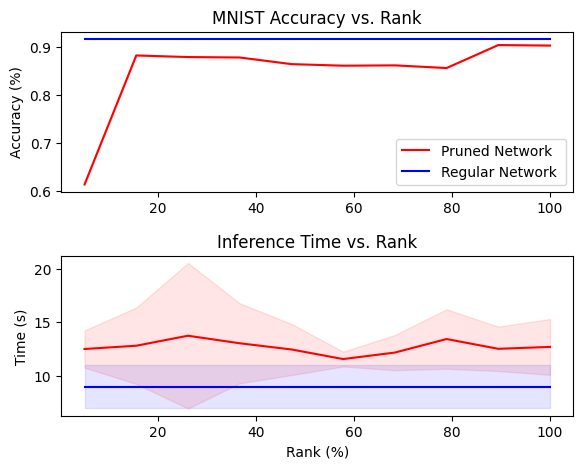

In [31]:
run_experiment(large_net, testloader)

In [1]:
large_net = LargeFCC().to(device)
train(large_net, trainloader, 10)

NameError: name 'LargeFCC' is not defined

In [28]:
run_trial(large_net, testloader, 1)

Accuracy (Mean, StD) on the 10000 test images: 91.60000000000001, 0.0 %
Time (Mean, StD) taken: 249.118878364563, 0.0 %


(0.916, 0.0, 249.118878364563, 0.0)

In [31]:
new_net = transform_model(large_net, 100)
run_trial(new_net, testloader, 1)

torch.Size([784, 100]) torch.Size([100, 128])
torch.Size([128, 100]) torch.Size([100, 512])
torch.Size([512, 100]) torch.Size([100, 2048])
torch.Size([2048, 100]) torch.Size([100, 8192])
torch.Size([8192, 100]) torch.Size([100, 2048])
torch.Size([2048, 100]) torch.Size([100, 512])
torch.Size([512, 100]) torch.Size([100, 128])
torch.Size([128, 64]) torch.Size([64, 64])
torch.Size([64, 10]) torch.Size([10, 10])
Accuracy (Mean, StD) on the 10000 test images: 73.14, 0.0 %
Time (Mean, StD) taken: 79.58860719203949, 0.0 %


(0.7314, 0.0, 79.58860719203949, 0.0)

Accuracy (Mean, StD) on the 10000 test images: 91.60000000000001, 0.0 %
Time (Mean, StD) taken: 275.2077575683594, 1.334595989546953 %
torch.Size([784, 10]) torch.Size([10, 128])
torch.Size([128, 10]) torch.Size([10, 512])
torch.Size([512, 10]) torch.Size([10, 2048])
torch.Size([2048, 10]) torch.Size([10, 8192])
torch.Size([8192, 10]) torch.Size([10, 2048])
torch.Size([2048, 10]) torch.Size([10, 512])
torch.Size([512, 10]) torch.Size([10, 128])
torch.Size([128, 10]) torch.Size([10, 64])
torch.Size([64, 10]) torch.Size([10, 10])
Accuracy (Mean, StD) on the 10000 test images: 10.100000000000001, 0.0 %
Time (Mean, StD) taken: 33.52232002019882, 4.336408595017763 %
torch.Size([784, 36]) torch.Size([36, 128])
torch.Size([128, 36]) torch.Size([36, 512])
torch.Size([512, 36]) torch.Size([36, 2048])
torch.Size([2048, 36]) torch.Size([36, 8192])
torch.Size([8192, 36]) torch.Size([36, 2048])
torch.Size([2048, 36]) torch.Size([36, 512])
torch.Size([512, 36]) torch.Size([36, 128])
torch.Size([128,

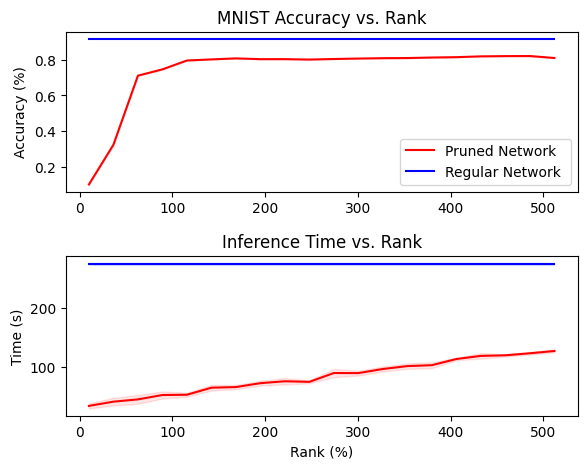

In [33]:
run_experiment(large_net, testloader)

# CNN experiments


In [7]:
from google.colab import drive

drive.mount('/content/drive/')

PATH = "/content/drive/MyDrive/18.065 Project"
! mkdir ./data
! cp -r "{PATH}/data/ILSVRC2012_img_val.tar" ./data
! cp -r "{PATH}/data/ILSVRC2012_devkit_t12.tar.gz" ./data

import os

Mounted at /content/drive/
mkdir: cannot create directory ‘./data’: File exists


In [8]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 16

trainset = torchvision.datasets.ImageNet(root='./data', transform=transform, split='val')
testset, trainset = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [81]:
resnet = models.resnet50(pretrained=True).to(device).eval()
replace_layers(resnet, nn.Conv2d)
# print(resnet)
# run_trial(resnet, testloader, 1)
# randomized_alexnet = models.alexnet(pretrained=True).to(device).eval()
# replace_conv_layers(randomized_alexnet, True)

In [ ]:
run_trial(resnet, testloader, 1)

In [ ]:
print(resnet)

In [ ]:
import copy
low_rank_resnet = copy.deepcopy(resnet)
transform_model(low_rank_resnet, 1)
print(low_rank_resnet)

In [ ]:
run_trial(low_rank_resnet, testloader, 1)


In [ ]:
original_accuracy, original_time = evaluate_network(resnet, testloader)
print(f'Original Accuracy (resnet): {original_accuracy} %')
print(f'Time taken for original network: {original_time} seconds')

original_accuracy, original_time = evaluate_network(alexnet, testloader)
print(f'Original Accuracy (alexnet): {original_accuracy} %')
print(f'Time taken for original network: {original_time} seconds')

original_accuracy, original_time = evaluate_network(densenet, testloader)
print(f'Original Accuracy (densenet): {original_accuracy} %')
print(f'Time taken for original network: {original_time} seconds')

KeyboardInterrupt: 

In [ ]:
def replace_conv_with_low_rank(model, rank):
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            setattr(model, name, init_low_rank_weights(module, rank))
        elif len(list(module.children())) > 0:
            replace_conv_with_low_rank(module, rank)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LowRankConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True, rank=10):
        super().__init__()
        self.k = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.rank = rank

        self.full_weight = nn.Parameter(torch.randn(out_channels, in_channels, *self.k))
        self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

        self.weight = None

    def forward(self, x):
        self.apply_low_rank_approximation()
        return self.custom_convolution(x)

    def apply_low_rank_approximation(self):
        reshaped_weight = self.full_weight.reshape(self.full_weight.size(0), -1)
        u, s, vt = torch.linalg.svd(reshaped_weight, full_matrices=False)

        u = u[:, :self.rank]
        s = s[:self.rank]
        vt = vt[:self.rank, :]

        self.weight = torch.mm(torch.diag(s), vt).reshape(self.full_weight.shape)

    def custom_convolution(self, x):
        out = F.conv2d(x, self.weight, self.bias, self.stride, self.padding)
        return out

In [ ]:
class LowRankConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=True, rank=10):
        super(LowRankConv2d, self).__init__()

def init_low_rank_weights(original_conv, rank):
    kernel_size = original_conv.kernel_size if isinstance(original_conv.kernel_size, tuple) \
                  else (original_conv.kernel_size, original_conv.kernel_size)
    stride = original_conv.stride if isinstance(original_conv.stride, tuple) \
             else (original_conv.stride, original_conv.stride)
    padding = original_conv.padding if isinstance(original_conv.padding, tuple) \
              else (original_conv.padding, original_conv.padding)
    low_rank_layer = LowRankConv2d(original_conv.in_channels, original_conv.out_channels,
                                   kernel_size, stride, padding, original_conv.bias is not None, rank)

replace_conv_with_low_rank(alexnet, rank=10)
replace_conv_with_low_rank(resnet, rank=10)
replace_conv_with_low_rank(densenet, rank=10)


In [ ]:
replace_conv_with_low_rank(resnet, rank=10)

low_rank_accuracy, low_rank_time = evaluate_network(resnet, testloader)
print(f'Low-Rank Approx Accuracy (resnet): {low_rank_accuracy} %')
print(f'Time taken for low-rank approx network: {low_rank_time} seconds')

In [ ]:
replace_conv_with_low_rank(alexnet, rank=10)

low_rank_accuracy, low_rank_time = evaluate_network(alexnet, testloader)
print(f'Low-Rank Approx Accuracy (alexnet): {low_rank_accuracy} %')
print(f'Time taken for low-rank approx network: {low_rank_time} seconds')

In [ ]:
replace_conv_with_low_rank(densenet, rank=10)

low_rank_accuracy, low_rank_time = evaluate_network(densenet, testloader)
print(f'Low-Rank Approx Accuracy (densenet): {low_rank_accuracy} %')
print(f'Time taken for low-rank approx network: {low_rank_time} seconds')

In [ ]:
run_trial(resnet, trainloader, 1)

# Custom Conv

In [9]:
import torch.nn.functional as F

class ManualConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, padding=0, bias=False):
        super().__init__()
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.weight = None
        # note that self.weight should be 2d matrix
        self.bias = None

    def forward(self, x):
        return self.custom_convolution(x)

    def custom_convolution(self, x):
        # x = x.double()
        k = self.k
        stride = self.stride
        h_in, w_in = x.shape[2], x.shape[3]

        padding = self.padding  # + k//2
        batch_size = x.shape[0]

        h_out = (h_in + 2 * padding[0] - (k[0] - 1) - 1) / stride[0] + 1
        w_out = (w_in + 2 * padding[1] - (k[1] - 1) - 1) / stride[1] + 1
        h_out, w_out = int(h_out), int(w_out)

        inp_unf = torch.nn.functional.unfold(x, k, padding=padding, stride=stride)

        batch_flattened_inp_unf = inp_unf.transpose(1, 2).reshape(-1, inp_unf.transpose(1, 2).size(2))

        ############
        batch_flattened_out_unf = batch_flattened_inp_unf @ self.weight.t()
        ############

        out_unf = batch_flattened_out_unf.reshape(batch_size, inp_unf.transpose(1, 2).shape[1], -1).transpose(1,2)

        # out_unf = inp_unf.transpose(1, 2).matmul(self.weight.view(self.weight.size(0), -1).t()).transpose(1,2)

        out = torch.nn.functional.fold(out_unf, (h_out, w_out), (1, 1))
        if self.bias is not None:
          out = self.bias[None, :, None, None] + out

        return out

class LowRankConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1, padding=0, bias=True):
        super().__init__()
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.weight1 = None
        self.weight2 = None
        self.bias = None

    def forward(self, x):
        return self.custom_convolution(x)

    def custom_convolution(self, x):
        # x = x.double()
        k = self.k
        stride = self.stride
        h_in, w_in = x.shape[2], x.shape[3]

        padding = self.padding  # + k//2
        batch_size = x.shape[0]

        h_out = (h_in + 2 * padding[0] - (k[0] - 1) - 1) / stride[0] + 1
        w_out = (w_in + 2 * padding[1] - (k[1] - 1) - 1) / stride[1] + 1
        h_out, w_out = int(h_out), int(w_out)

        inp_unf = torch.nn.functional.unfold(x, k, padding=padding, stride=stride)

        batch_flattened_inp_unf = inp_unf.transpose(1, 2).reshape(-1, inp_unf.transpose(1, 2).size(2))

        ############
        batch_flattened_out_unf = batch_flattened_inp_unf @ self.weight2.t() @ self.weight1.t()
        ############

        out_unf = batch_flattened_out_unf.reshape(batch_size, inp_unf.transpose(1, 2).shape[1], -1).transpose(1,2)

        # out_unf = inp_unf.transpose(1, 2).matmul(self.weight.view(self.weight.size(0), -1).t()).transpose(1,2)

        out = torch.nn.functional.fold(out_unf, (h_out, w_out), (1, 1))
        if self.bias is not None:
          out = self.bias[None, :, None, None] + out

        return out


In [10]:
import torchvision.models as models
def replace_layers(net, layer_type):

    for name, module in net.named_children():
        if isinstance(module, layer_type):
            # print(type(module))
            layer = module
            if layer_type == nn.Conv2d:
                weight_matrix = layer.weight.data
                if layer.bias is not None:
                    bias_matrix = layer.bias.data
                new = ManualConv2d(in_channels=layer.in_channels,
                                          out_channels=layer.out_channels,
                                          kernel_size=layer.kernel_size,
                                          padding=layer.padding,
                                          stride=layer.stride,
                                          bias = True if layer.bias is not None else False)
                weight_matrix = weight_matrix.view(weight_matrix.size(0), -1)
                new.weight = weight_matrix
                if layer.bias is not None:
                    new.bias = bias_matrix
            # if layer_type == nn.Linear:
            #     weight_matrix = layer.weight.data
            #     if layer.bias is not None:
            #         bias_matrix = layer.bias.data
            #     if randomized:
            #         new = RandomizedLinear(weight_matrix, bias_matrix)
            #     else:
            #         new = CustomLinear(weight_matrix, bias_matrix)
            setattr(net, name, new)
        elif len(list(module.children())) > 0:
            replace_layers(module, layer_type)



In [11]:
import copy
def transform_model_cnn(model, k):
  for name, module in model.named_children():
      if isinstance(module, ManualConv2d):
          layer=module
          weight_matrix = layer.weight.data.cpu().numpy()


          low_rank_weight1, low_rank_weight2 = low_rank_approx(weight_matrix, k)
          # print('Weight shape: ', weight_matrix.shape, low_rank_weight1.shape, low_rank_weight2.shape)

          new = LowRankConv2d(in_channels=layer.in_c,
                                              out_channels=layer.out_c,
                                              kernel_size=layer.k,
                                              stride=layer.stride,
                                              dilation=layer.dilation,
                                              padding=layer.padding,
                                              bias=True if layer.bias is not None else False)
          new.weight1 = low_rank_weight2.t()
          new.weight2 = low_rank_weight1.t()
          if layer.bias is not None:
              new.bias = layer.bias.data

          setattr(model, name, new)
      elif len(list(module.children())) > 0:
          transform_model_cnn(module, k)


  # new_model = copy.deepcopy(model)
  # for i, (layer, new_layer) in enumerate(zip(model.layers, new_model.layers)):
  #   if isinstance(layer, ManualConv2d):
  #       weight_matrix = layer.weight.data.cpu().numpy()


  #       low_rank_weight1, low_rank_weight2 = low_rank_approx(weight_matrix, k)

  #       new_model.layers[i] = LowRankConv2d(in_channels=layer.in_c,
  #                                           out_channels=layer.out_c_c,
  #                                           kernel_size=layer.k,
  #                                           stride=layer.stride,
  #                                           dilation=layer.dilation,
  #                                           padding=layer.padding,
  #                                           bias=True if layer.bias is not None else False)
  #       new_model.layers[i].weight1 = low_rank_weight1
  #       new_model.layers[i].weight2 = low_rank_weight2

  # return new_model

In [11]:
from google.colab import drive

drive.mount('/content/drive/')

PATH = "/content/drive/MyDrive/18.065 Project"
! mkdir ./data
! cp -r "{PATH}/data/ILSVRC2012_img_val.tar" ./data
! cp -r "{PATH}/data/ILSVRC2012_devkit_t12.tar.gz" ./data

import os

Mounted at /content/drive/


In [12]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64

trainset = torchvision.datasets.ImageNet(root='./data', transform=transform, split='val')
testset, trainset = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [27]:
resnet = models.resnet50(pretrained=True).to(device).eval()
run_trial(resnet, testloader, 1)
replace_layers(resnet, nn.Conv2d)
low_rank_resnet = copy.deepcopy(resnet)
transform_model_cnn(low_rank_resnet, 1000)
run_trial(resnet, testloader, 1)
run_trial(low_rank_resnet, testloader, 1)

Accuracy (Mean, StD) on the 10000 test images: 60.9, 0.0 %
Time (Mean, StD) taken: 11788.802648544312, 0.0 %
torch.Size([1024, 1000]) torch.Size([1000, 2048])
Accuracy (Mean, StD) on the 10000 test images: 60.9, 0.0 %
Time (Mean, StD) taken: 17455.625022888184, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 57.3, 0.0 %
Time (Mean, StD) taken: 19924.442273139954, 0.0 %


(0.573, 0.0, 19924.442273139954, 0.0)

In [13]:
def run_experiment_cnn(regular_net, testloader):
  acc_mean_control, acc_std_control, time_mean_control, time_std_control = run_trial(regular_net, testloader, 5)
  acc_mean, acc_std, time_mean, time_std = [], [], [], []
  trials = np.linspace(5, 800, 15)
  for t in trials:
      new_net = copy.deepcopy(regular_net)
      transform_model_cnn(new_net, int(t))
      result = run_trial(new_net, testloader, 20)
      acc_mean.append(result[0])
      acc_std.append(result[1])
      time_mean.append(result[2])
      time_std.append(result[3])

  acc_mean = np.array(acc_mean)
  acc_std = np.array(acc_std)
  time_mean = np.array(time_mean)
  time_std = np.array(time_std)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(trials, acc_mean, color='red', label='Pruned Network')
  ax1.plot(trials, [acc_mean_control] * len(trials), color='blue', label='Regular Network ')
  ax1.fill_between(trials, acc_mean-acc_std, acc_mean+acc_std,
      alpha=0.1, color='red')

  ax1.set_title('Accuracy vs. Rank')
  ax1.set_ylabel('Accuracy (%)')

  ax1.legend(loc="lower right")


  ax2.plot(trials, time_mean, color='red', label='Pruned Network')
  ax2.plot(trials, [time_mean_control] * len(trials), color='blue', label='Regular Network')
  ax2.fill_between(trials, time_mean-time_std, time_mean+time_std,
      alpha=0.1, color='red')
  ax2.fill_between(trials, [time_mean_control - time_std_control] * len(trials), [time_mean_control + time_std_control] * len(trials),
      alpha=0.1, color='blue')

  ax2.set_title('Inference Time vs. Rank')
  ax2.set_xlabel('Rank (%)')
  ax2.set_ylabel('Time (s)')

  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)



  plt.show()

Accuracy (Mean, StD) on the 10000 test images: 62.6, 0.0 %
Time (Mean, StD) taken: 18149.79602470398, 599.2589935690993 %
torch.Size([147, 5]) torch.Size([5, 64])
torch.Size([64, 5]) torch.Size([5, 64])
torch.Size([576, 5]) torch.Size([5, 64])
torch.Size([64, 5]) torch.Size([5, 256])
torch.Size([64, 5]) torch.Size([5, 256])
torch.Size([256, 5]) torch.Size([5, 64])
torch.Size([576, 5]) torch.Size([5, 64])
torch.Size([64, 5]) torch.Size([5, 256])
torch.Size([256, 5]) torch.Size([5, 64])
torch.Size([576, 5]) torch.Size([5, 64])
torch.Size([64, 5]) torch.Size([5, 256])
torch.Size([256, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 128])
torch.Size([128, 5]) torch.Size([5, 512])
torch.Size([256, 5]) torch.Size([5, 512])
torch.Size([512, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 128])
torch.Size([128, 5]) torch.Size([5, 512])
torch.Size([512, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 128])
torch.Size([128, 5]) torch.Size([5, 512])
torch

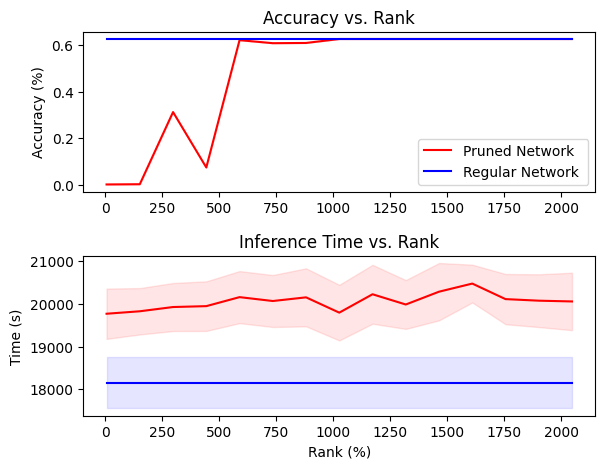

In [37]:
run_experiment_cnn(resnet, testloader)

Accuracy (Mean, StD) on the 10000 test images: 33.900000000000006, 0.0 %
Time (Mean, StD) taken: 2554.0812454223633, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 33.900000000000006, 0.0 %
Time (Mean, StD) taken: 3456.4111359119415, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 33.900000000000006, 0.0 %
Time (Mean, StD) taken: 3854.0835518836975, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 33.900000000000006, 0.0 %
Time (Mean, StD) taken: 3409.2271142959594, 158.7571248241406 %
torch.Size([363, 5]) torch.Size([5, 64])
torch.Size([1600, 5]) torch.Size([5, 192])
torch.Size([1728, 5]) torch.Size([5, 384])
torch.Size([3456, 5]) torch.Size([5, 256])
torch.Size([2304, 5]) torch.Size([5, 256])
Accuracy (Mean, StD) on the 10000 test images: 0.0, 0.0 %
Time (Mean, StD) taken: 3661.702064871788, 195.45034152694933 %
torch.Size([363, 61]) torch.Size([61, 64])
torch.Size([1600, 61]) torch.Size([61, 192])
torch.Size([1728, 61]) torch.Size([61, 384])
torch.Size([3456, 61]) tor

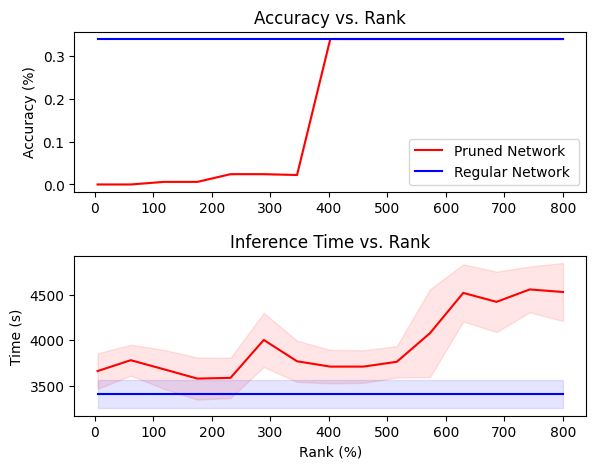

In [43]:
alexnet = models.alexnet(pretrained=True).to(device).eval()
run_trial(alexnet, testloader, 1)
replace_layers(alexnet, nn.Conv2d)
low_rank_alexnet = copy.deepcopy(alexnet)
transform_model_cnn(low_rank_alexnet, 1000)
run_trial(alexnet, testloader, 1)
run_trial(low_rank_alexnet, testloader, 1)
run_experiment_cnn(alexnet, testloader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this wil

Accuracy (Mean, StD) on the 10000 test images: 65.3, 0.0 %
Time (Mean, StD) taken: 24977.509028434753, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 65.3, 0.0 %
Time (Mean, StD) taken: 37189.277391433716, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 65.3, 0.0 %
Time (Mean, StD) taken: 40526.27910041809, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 65.3, 0.0 %
Time (Mean, StD) taken: 37573.748871994016, 449.6035571131037 %
torch.Size([147, 5]) torch.Size([5, 64])
torch.Size([64, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 32])
torch.Size([96, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 32])
torch.Size([128, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 32])
torch.Size([160, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 32])
torch.Size([192, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 32])
torch.Size([224, 5]) torch.Size([5, 128])
torch.Size([1152, 5]) torch.Size([5, 32])
torch.Si

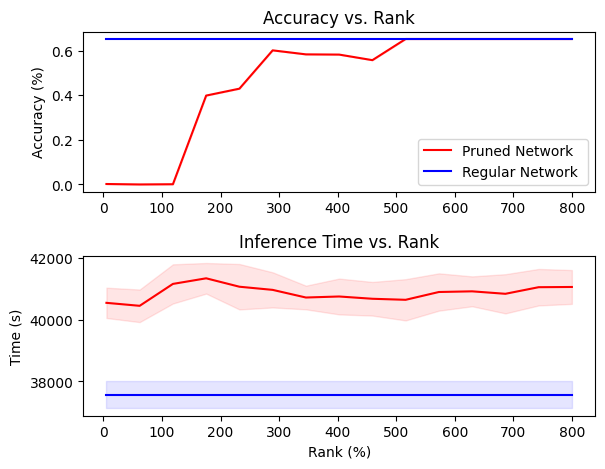

In [14]:
densenet = models.densenet121(pretrained=True).to(device).eval()
run_trial(densenet, testloader, 1)
replace_layers(densenet, nn.Conv2d)
low_rank_densenet = copy.deepcopy(densenet)
transform_model_cnn(low_rank_densenet, 1000)
run_trial(densenet, testloader, 1)
run_trial(low_rank_densenet, testloader, 1)
run_experiment_cnn(densenet, testloader)


In [ ]:
q